In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import fashion_mnist
((x_train, y_train), (x_test, y_test)) = fashion_mnist.load_data()

/home/archana/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/archana/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/archana/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/archana/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

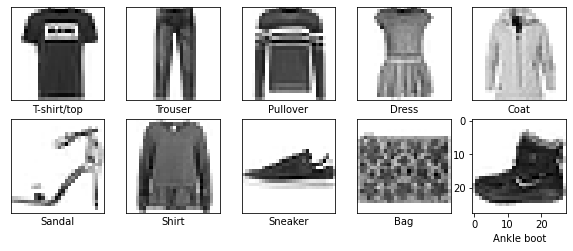

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

_, indicesList = np.unique(y_train, return_index=True)

plt.figure(figsize=(10,10))
for i in range(10):
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5,5,i+1)
#     plt.grid(False)
    plt.imshow(x_train[indicesList[i]] , cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

In [4]:
def sigmoid(x):
    x = np.clip(x, a_min = -700, a_max = 700)
    return (1/(1+ np.exp(-x)))

def sigmoid_grad(x):
    a = sigmoid(x)
    return a*(1-a)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    a = tanh(x)
    return 1 - a*a

def relu(x):
    x[x<0] = 0
    return x

def relu_grad(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [5]:
activations = {
    "sigmoid": [sigmoid,sigmoid_grad],
    "tanh": [tanh,tanh_grad],
    "relu": [relu,relu_grad]
}

In [6]:
def cross_entropy_loss(real,pred):
    ret = -np.sum(np.multiply(real,np.log(pred)) , axis = 1)
    return ret

def cross_entropy_loss_grad(real,pred):
    return -(real-pred)

def mse_loss(real,pred):
    ret = np.mean((pred-real)**2)/2
    return ret
    
def mse_loss_grad(real,pred):
    return pred-real

In [7]:
losses = {
    "cross_entropy":(cross_entropy_loss,cross_entropy_loss_grad),
    "mse": (mse_loss,mse_loss_grad)
}

In [8]:
class layer:
    
    def __init__(self,neurons,inputs,activation = None):
        self.W = np.random.randn(inputs,neurons)
        self.b = np.random.randn(neurons,)
        self.neurons = neurons
        self.inputs = inputs
        if activation is None:
            self.activation = activations["relu"]
        else:
            self.activation = activations[activation]
            
    def run_layer(self,A):
        a = np.dot(A,self.W) +self.b      #a is not dot product
        self.inp = A
        return self.activation[0](a)
    
    def back_pass(self,dl_da,lr=0.01):
        dl_da_curr = np.dot(dl_da,self.W.T)
        dl_dw = np.dot(self.inp.T,dl_da)
        dl_db = np.mean(dl_da,axis=0)
        
        self.W -= lr * dl_dw
        self.b -= lr * dl_db
        
        return dl_da_curr

In [9]:
class models:
    
    def __init__(self,inputs,loss=None,optimizer=None):
        self.inputs = inputs
        self.layers = []
        if loss is None:
            self.loss = losses["cross_entropy"]
        else:
            self.loss = losses[loss]
        self.optimizer = optimizer
        
        
    def add_layer(self,neurons,activation=None):
        if len(self.layers) == 0:
            inps = self.inputs
        else:
            inps = self.layers[-1].neurons
        new_layer = layer(neurons,inps,activation)
        self.layers.append(new_layer)
        
        
    def forward_pass(self,inputs):
        res = inputs
        for lay in self.layers:
            res = lay.run_layer(res)
            
        return res
    
    def print(self):
        for lay in self.layers:
            print("Layer : ")
            print("Input: {}".format(lay.inputs))
            print("Neurons: {}".format(lay.neurons))
            
    def backward_pass(self,dl_da):
        dd = dl_da
        for lay in reversed(self.layers) :
            dd = lay.back_pass(dd)
    
    def predict(self,inputs):
        return self.forward_pass(inputs)
    
    
    def train(self,inputs,outputs,epochs):
        loss_tracker = []
        for i in range(epochs):
            pred = self.predict(inputs)
            loss = self.loss[0](outputs,pred)
            loss_tracker.append(loss)
            da = self.loss[1](outputs,pred)
            self.backward_pass(da)
            

In [10]:
def transx(x):
    l,b,h = x.shape
    xt = x.reshape((l,b*h))
    return xt

In [11]:
xt = transx(x_train)
print(xt)
xt = xt/256
print(xt)
print(xt.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 784)


In [12]:
def one_hot_encoding(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size),a] = 1
    return b

yt = one_hot_encoding(y_train)
print(yt.shape)

(60000, 10)


In [13]:
model = models(784)
model.add_layer(64)
model.add_layer(32)
model.add_layer(len(class_names),activation="sigmoid")
model.print()

Layer : 
Input: 784
Neurons: 64
Layer : 
Input: 64
Neurons: 32
Layer : 
Input: 32
Neurons: 10


In [14]:
model.train(xt,yt,100)

In [15]:
xte = transx(x_test)
pred = np.argmax(model.predict(xte))

In [16]:
print(np.sum(pred==y_test)/y_test.shape[0])

0.1
